In [1]:
import numpy as np
import cupy as cp
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import h5py
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")


sys.path.insert(0, '..')
from utils import *
from rec import Rec

# find shift with 1 pixel accuracy

In [2]:
z1c = -17.75e-3
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 1.286e-3
z1 = 5.5e-3-sx0
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications)

# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distancec = (z1-z1c)/(z1c/z1)#magnifications2

show = True

In [3]:
args = SimpleNamespace()
args.npos = 1
args.ngpus = 4
args.lam = 0.1

args.n = 1024
voxelsize *= 2048/args.n
args.ntheta = 3*2048//2*args.n//2048
args.theta = np.linspace(0,np.pi,args.ntheta,dtype='float32')
args.ncode = 8704*args.n//2048
args.pad = args.n // 8
args.npsi = args.n + 2 * args.pad
args.nq = args.n + 2 * args.pad
args.ex = 8
args.npatch = args.nq + 2 * args.ex
args.nchunk = 4

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.distancec = distancec
args.eps = 1e-12
args.rho = [1, 0.5, 0.1]
args.crop = 0#2 * args.pad
args.path_out = f"/data/vnikitin/ESRF/ID16A/20240924_rec0224/SiemensLH/SiemensLH_010nm_code2um_nfp9x9_01/{args.lam}_{args.rho[1]}_{args.rho[2]}"


args.niter = 1
args.err_step = 1
args.vis_step = 1
args.method = "BH-CG"
args.show = True
args.rotation_axis = args.npsi/2
# create class
cl_rec = Rec(args)


In [4]:
shifts_code = ((np.random.random([args.ntheta,2]).astype('float32')-0.5)*1000).astype('int32')

In [5]:
ri = np.round(shifts_code).astype('int32')
r = (shifts_code-ri).astype('float32')

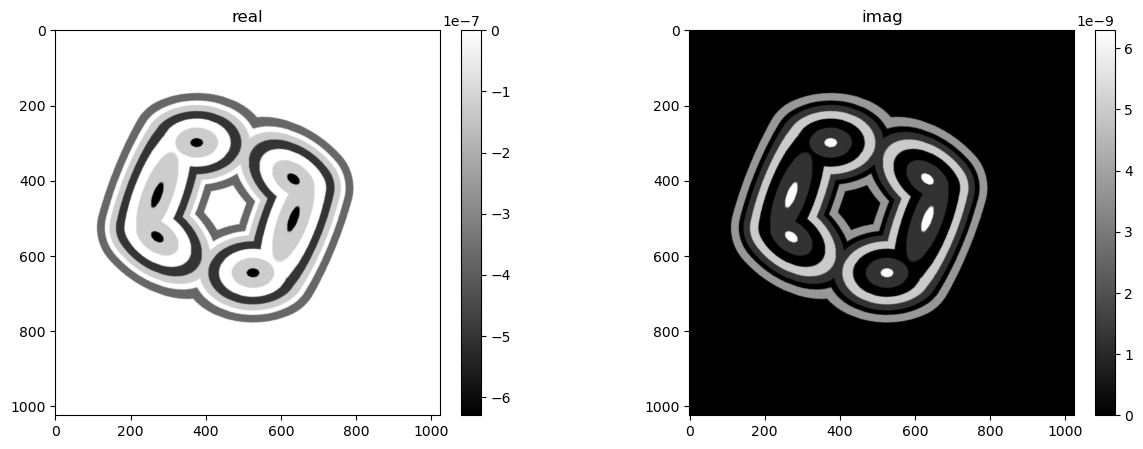

In [6]:
u0= np.load(f'/data/vnikitin/syn_3d_ald/u{args.n}.npy').astype('complex64')/4
mshow_complex(u0[u0.shape[0]//2],show)

128
(18.463406-1.8731015e-06j)
(18.463413-2.9240057e-13j)


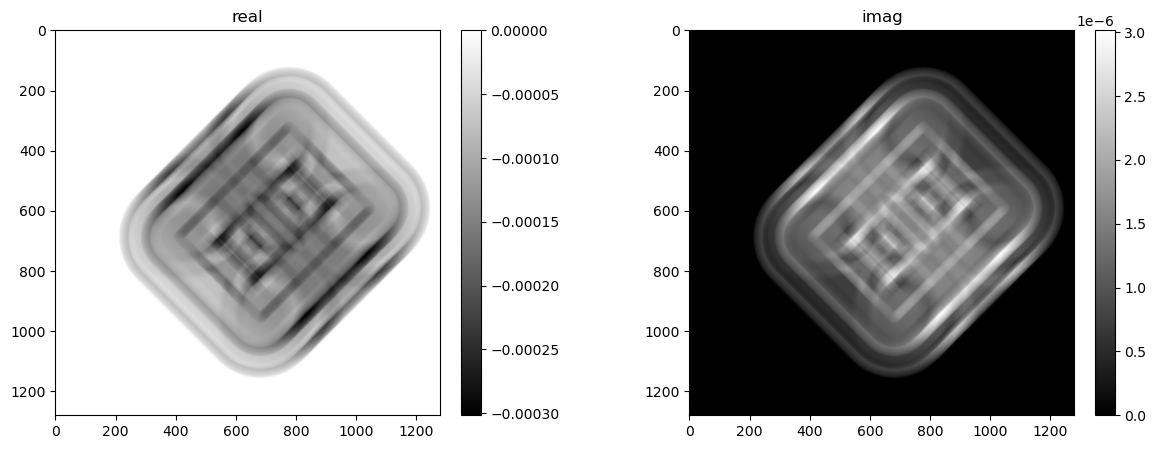

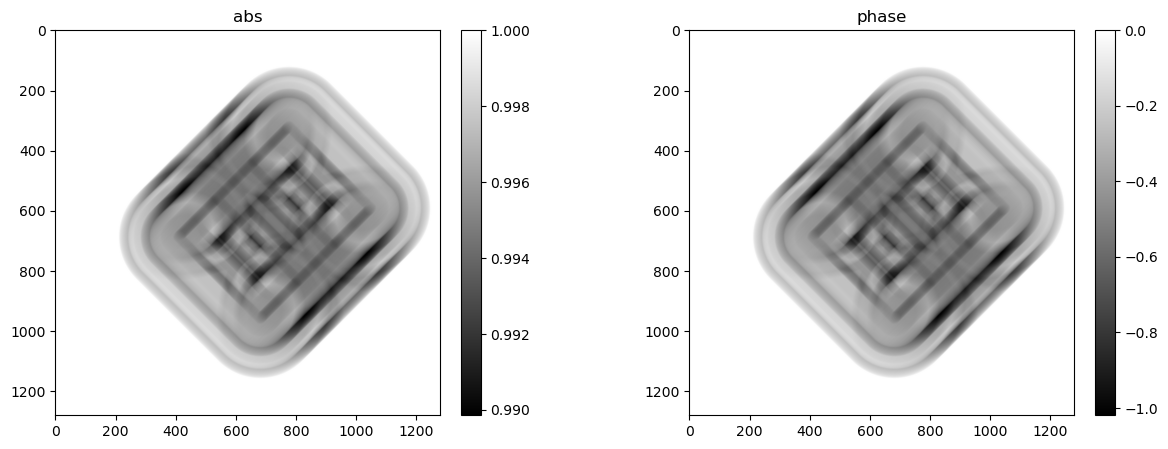

In [7]:
import scipy.ndimage as ndimage
print(args.pad)

u = ndimage.zoom(u0,1.5,order=1)
u = u[u.shape[0]//2-args.npsi//2:u.shape[0]//2+args.npsi//2,
      u.shape[0]//2-args.npsi//2:u.shape[0]//2+args.npsi//2,
      u.shape[0]//2-args.npsi//2:u.shape[0]//2+args.npsi//2]
# u = np.zeros([args.n,args.n,args.n],dtype='complex64')

# nn = args.n//128
# for z in range(nn):
#     for y in range(nn):
#         for x in range(nn):
#             u[z::nn,y::nn,x::nn] = u0
# u = np.pad(u,((args.pad,args.pad),(args.pad,args.pad),(args.pad,args.pad)))

# u=cp.array(u)
data = cl_rec.R(u)
uu = cl_rec.RT(data)

print(np.sum(u*uu.conj()))
print(np.sum(data*data.conj()))
mshow_complex(data[-1],True)

c =  args.voxelsize * 2*cp.pi / args.wavelength
edata = cl_rec.expR(data*c)
mshow_polar(edata[-1],True)



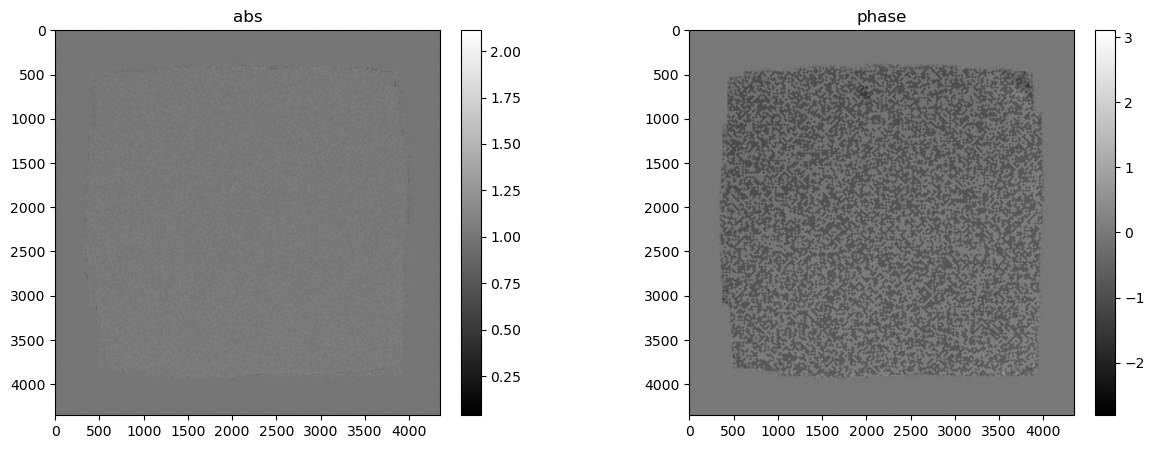

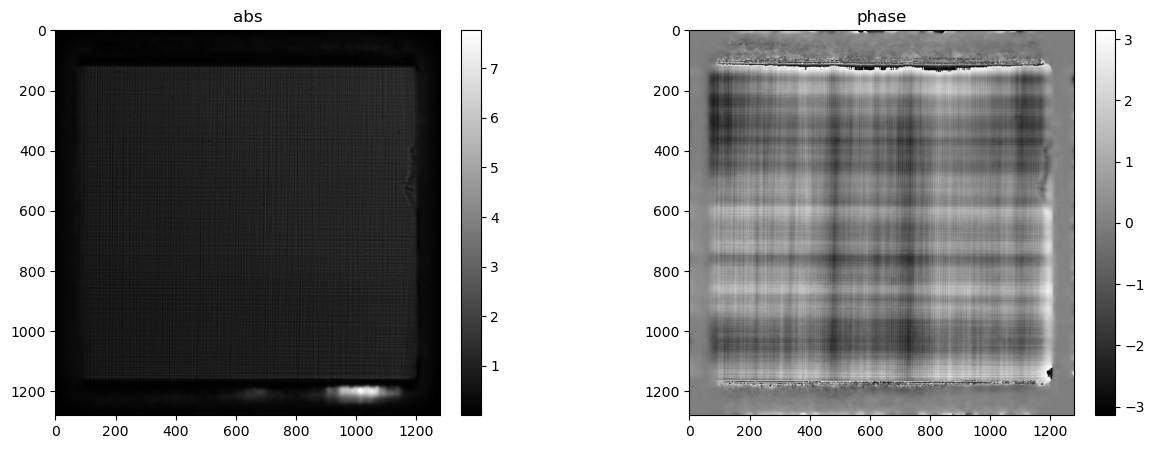

In [8]:
path_code = f"/data/vnikitin/ESRF/ID16A/20240924_rec0224/SiemensLH/code2um_nfp18x18_01/bets_final_256_0.1_2"
iter = 1664

cthickness = 1
code_angle = read_tiff(f"{path_code}/rec_psi_angle/{iter:04}.tiff")
code_abs = read_tiff(f"{path_code}/rec_psi_abs/{iter:04}.tiff")
code = np.exp(cthickness*(np.log(code_abs)+1j * code_angle))
for y in range(int(np.log2(2048//args.n))):
    code = 0.5*(code[::2]+code[1::2])
    code = 0.5*(code[:,::2]+code[:,1::2])

mshow_polar(code, args.show)

q_angle = read_tiff(f"{path_code}/rec_prb_angle/{iter:04}.tiff")
q_abs = read_tiff(f"{path_code}/rec_prb_abs/{iter:04}.tiff")
q = q_abs * np.exp(1j * q_angle)
for y in range(int(np.log2(2048//args.n))):
    q = 0.5*(q[::2]+q[1::2])
    q = 0.5*(q[:,::2]+q[:,1::2])
mshow_polar(q, args.show)

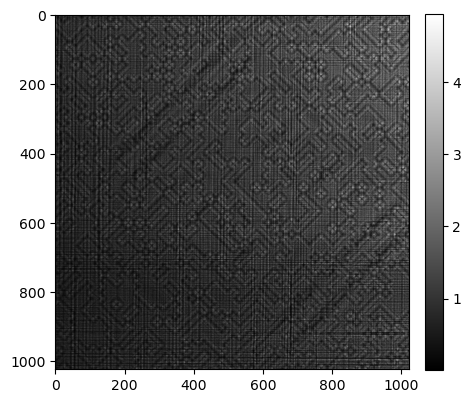

In [9]:
c =  args.voxelsize * 2*cp.pi / args.wavelength#*np.sqrt(args.npsi*args.ntheta)
u_new = (u*c).astype('complex64')
data = np.abs(cl_rec.fwd(ri,r,code,u_new,q))**2

mshow(data[-1],True)

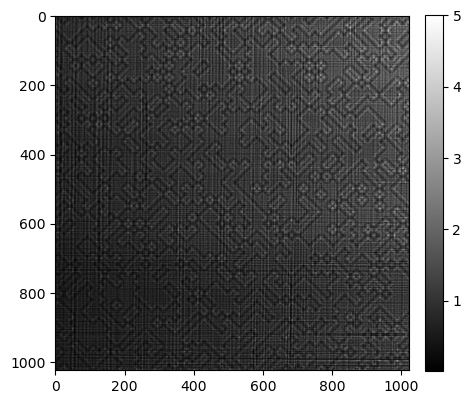

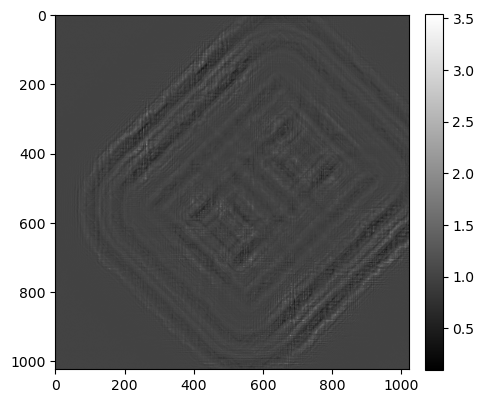

In [10]:
cdata = np.abs(cl_rec.fwd(ri,r,code,u_new*0,q))**2
mshow(cdata[-1],True)
rdata = data/cdata
mshow(rdata[-1],True)

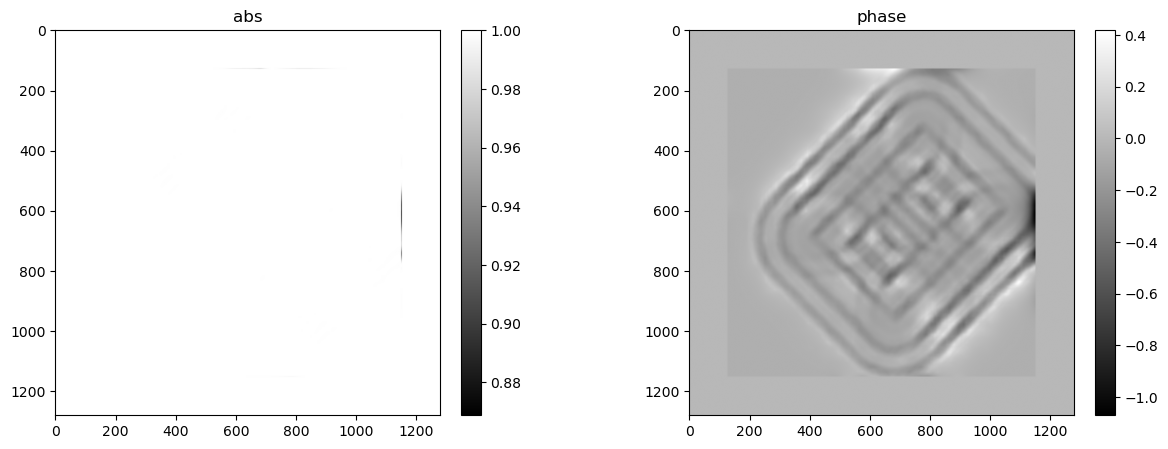

In [11]:
def Paganin(data, wavelength, voxelsize, delta_beta, alpha):
    n = data.shape[-1]
    fx = cp.fft.fftfreq(2*n, d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    data = np.pad(data,((n//2,n//2),(n//2,n//2)),'edge')
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2 + fy**2)
    numerator = taylorExp * (rad_freq)
    denominator = taylorExp**2 + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = delta_beta * 0.5 * phase
    phase = phase[n//2:-n//2,n//2:-n//2]
    return phase


def rec_init(rdata):
    recMultiPaganin = np.zeros([args.ntheta,args.npsi, args.npsi], dtype="float32")
    for j in range(0, args.ntheta):
        r = cp.array(rdata[j])
        #,'edge')
        r = Paganin(r, wavelength, voxelsize, 25.05, 4e-3)     
        r = cp.pad(r,((args.pad,args.pad),(args.pad,args.pad)))
        recMultiPaganin[j] = r.get()   
        

    recMultiPaganin = np.exp(1j * recMultiPaganin)
    return recMultiPaganin

psi_init = rec_init(rdata)

# smooth borders
v = np.arange(-args.npsi // 2,args.npsi // 2) / args.npsi
[vx, vy] = np.meshgrid(v, v)
v = np.exp(-20 * (vx**2 + vy**2)).astype("float32")

psi_init = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(psi_init)))
psi_init = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(psi_init * v))).astype(
    "complex64"
)

mshow_polar(psi_init[-1],args.show)

0
1
2
3
4
5
6
7
8
9


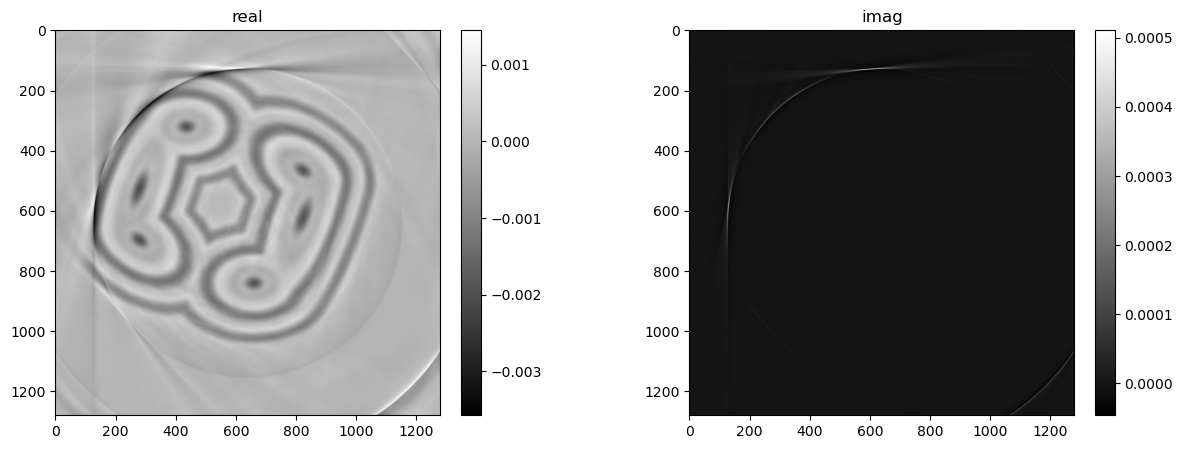

In [12]:
psi_data = np.log(psi_init)/1j
u_init = cl_rec.rec_tomo(psi_data)
mshow_complex(u_init[u_init.shape[0]//2],True)

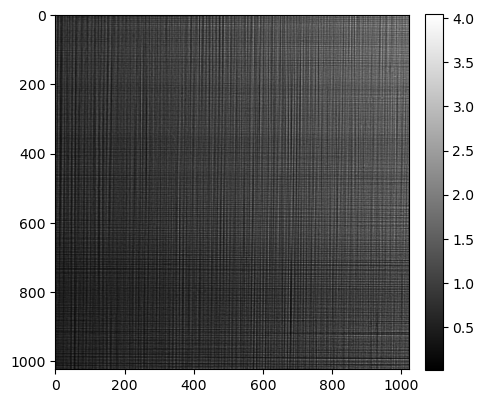

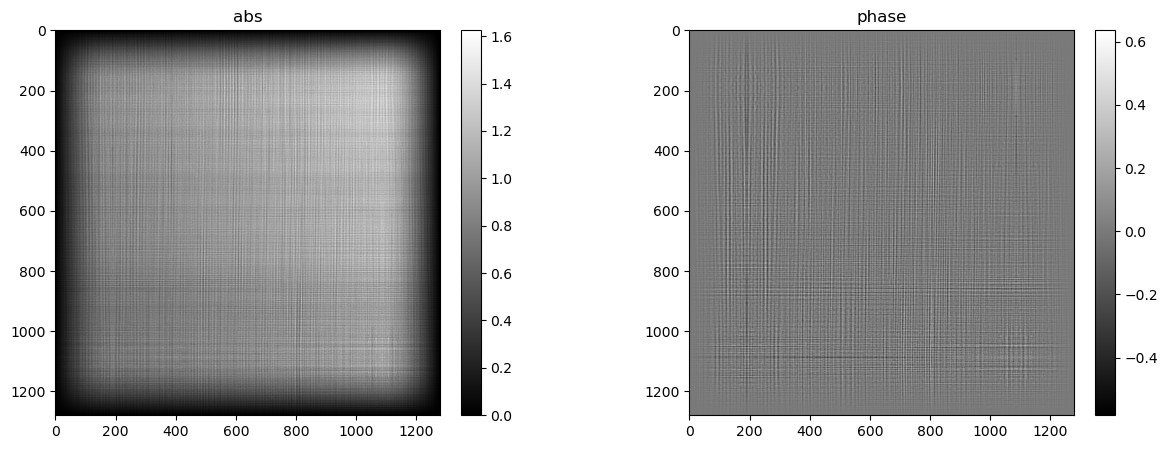

In [13]:
ref = np.abs(cl_rec.fwd(ri,r,code*0+1,u_new*0,q))**2
ref = ref[0]
mshow(ref,True)
q_init = cp.array(cl_rec.DcT(cl_rec.DT(np.sqrt(ref[np.newaxis])))[0])

ppad = 3 * args.pad // 2
q_init = np.pad(
    q_init[ppad : args.nq - ppad, ppad : args.nq - ppad],
    ((ppad, ppad), (ppad, ppad)),
    "symmetric",
)
v = cp.ones(args.nq, dtype="float32")
vv = cp.sin(cp.linspace(0, cp.pi / 2, ppad))
v[:ppad] = vv
v[args.nq - ppad :] = vv[::-1]
v = cp.outer(v, v)
q_init = cp.abs(q_init * v) * cp.exp(1j * cp.angle(q_init) * v)

mshow_polar(q_init,args.show)

0) err=1.89759e+07


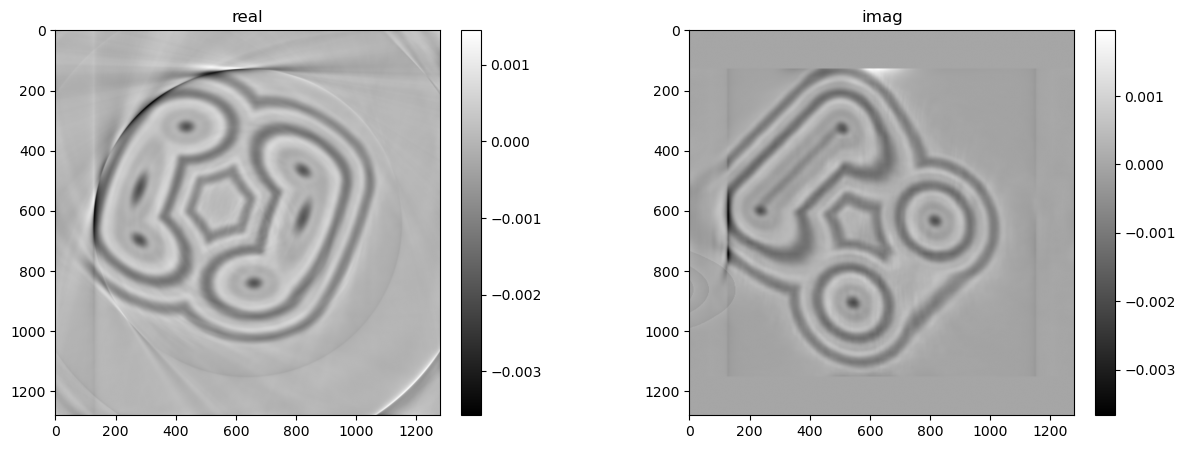

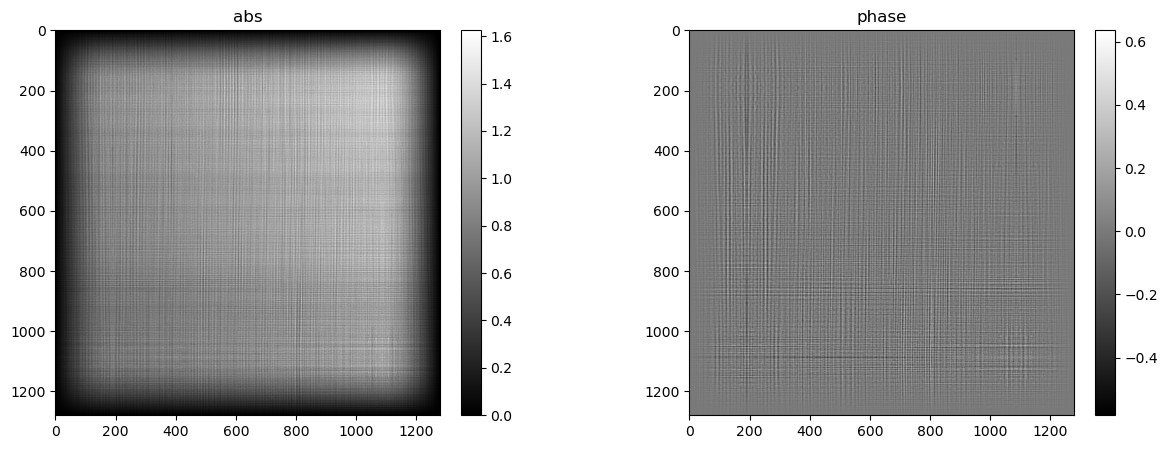

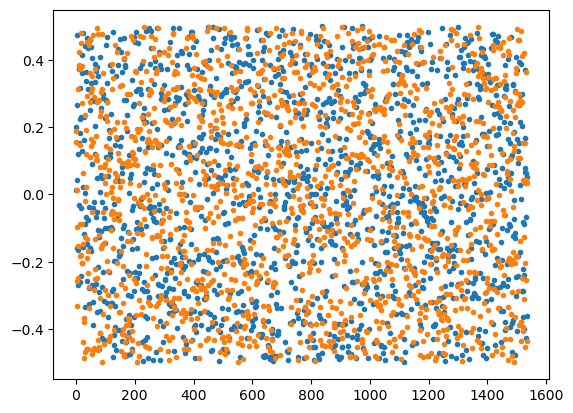

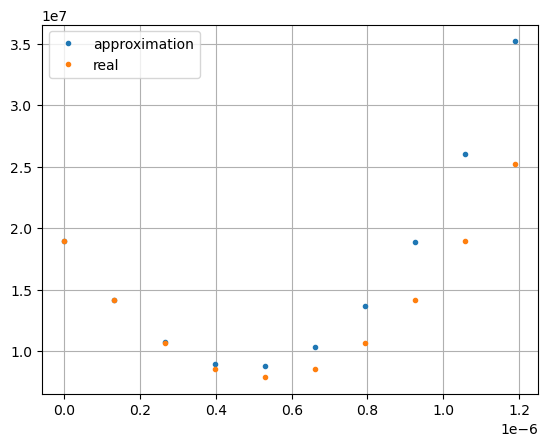

1) err=8.75771e+06
2) err=5.68778e+06
3) err=4.47169e+06
4) err=3.48140e+06


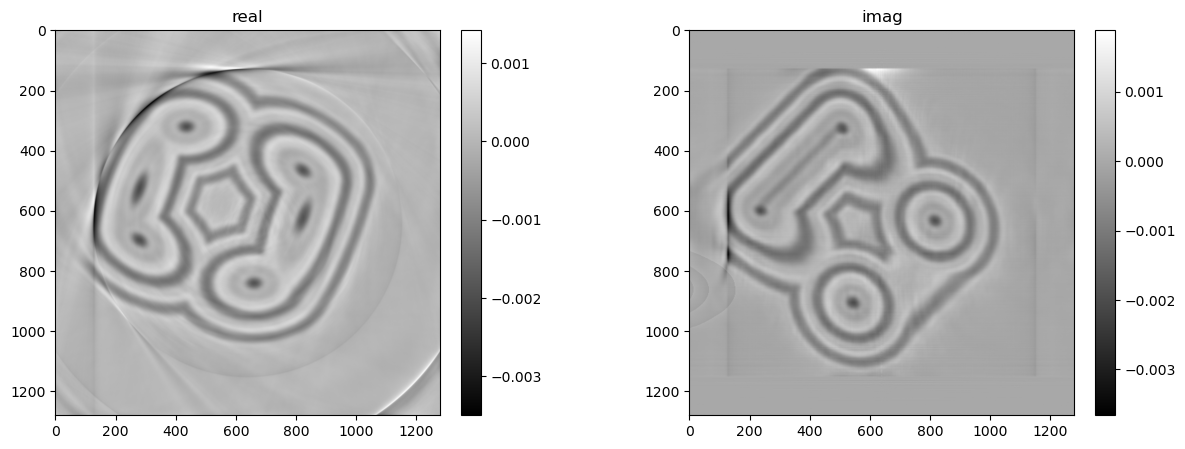

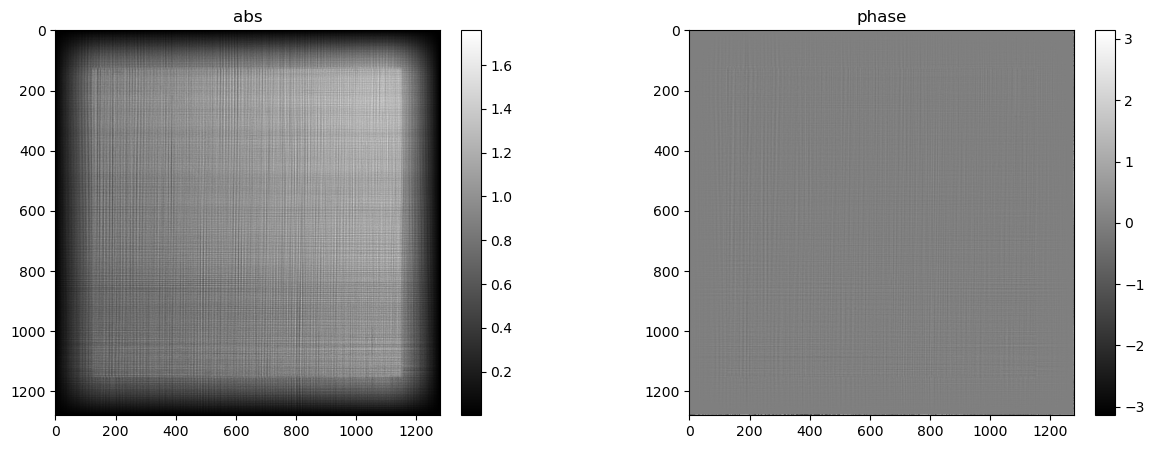

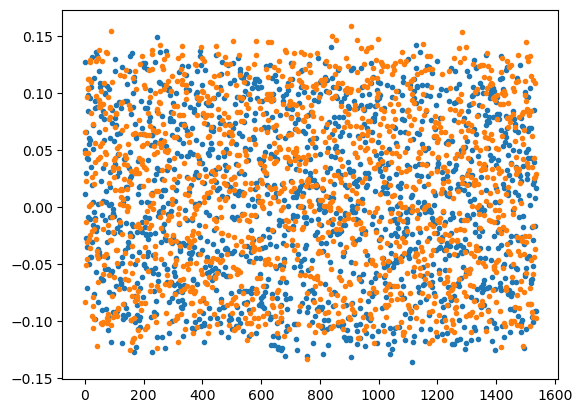

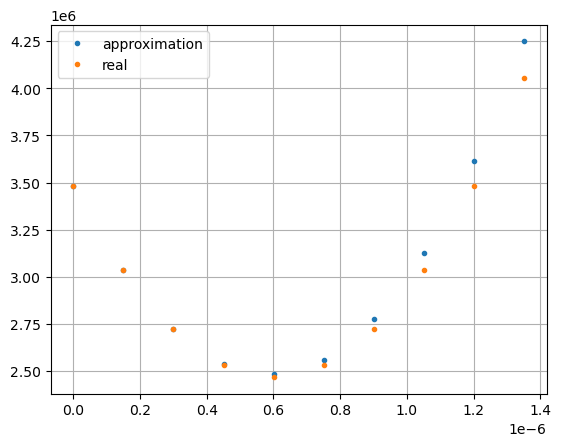

5) err=2.48077e+06
6) err=1.91425e+06
7) err=1.65408e+06
8) err=1.48417e+06


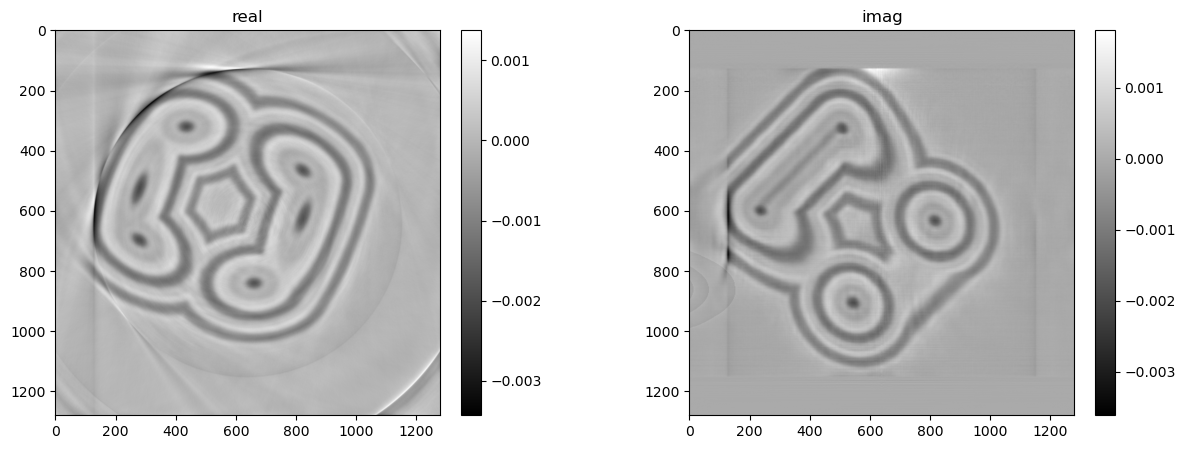

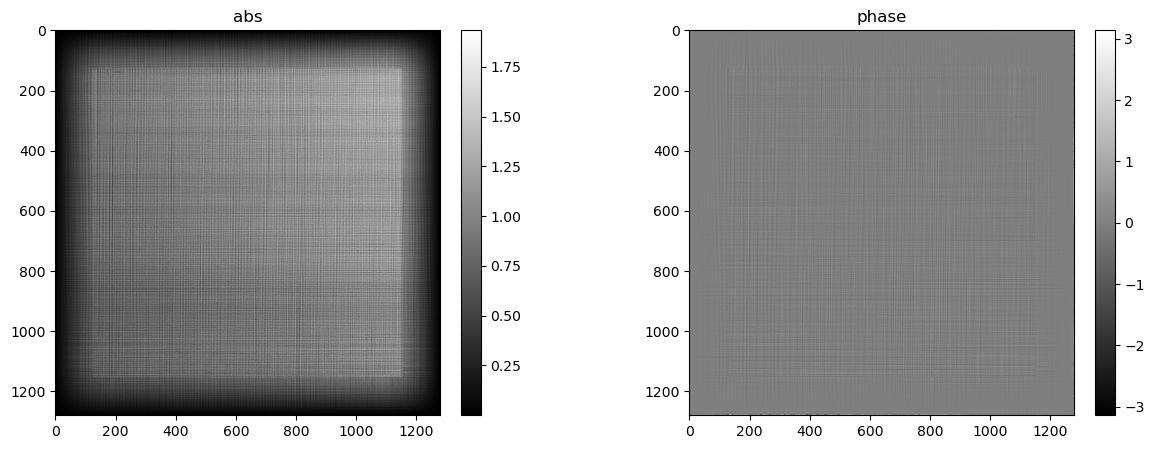

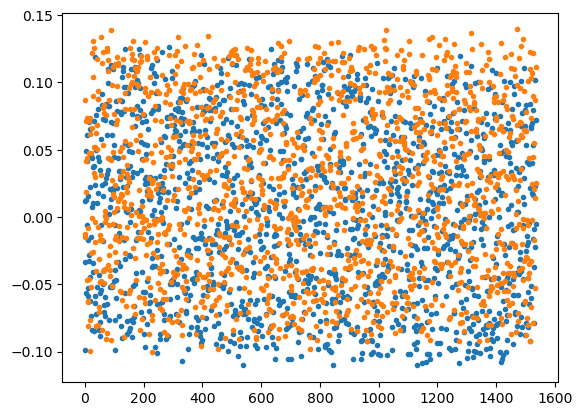

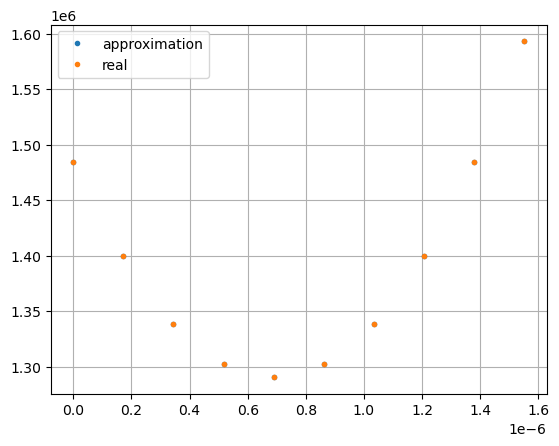

9) err=1.29030e+06
10) err=1.13924e+06
11) err=1.04638e+06
12) err=9.65468e+05


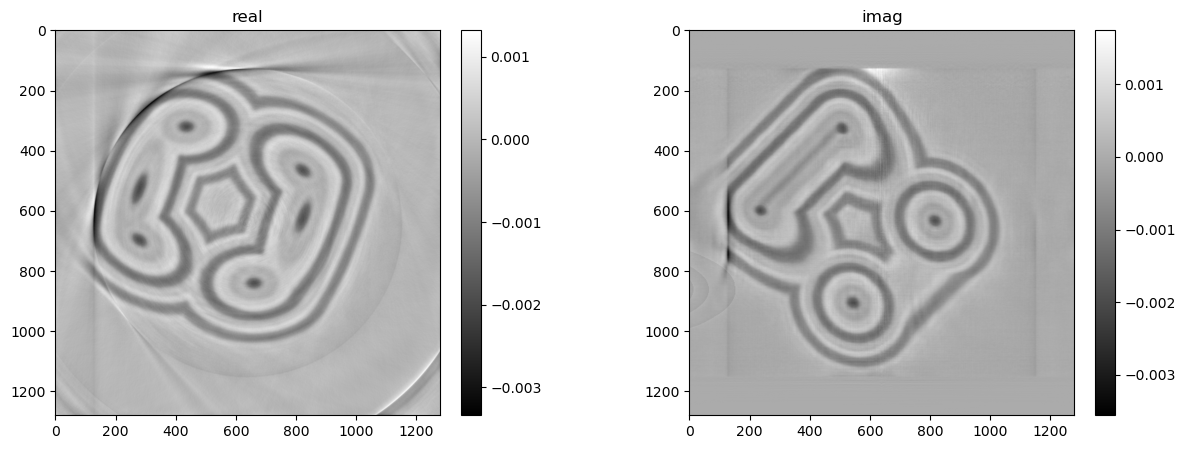

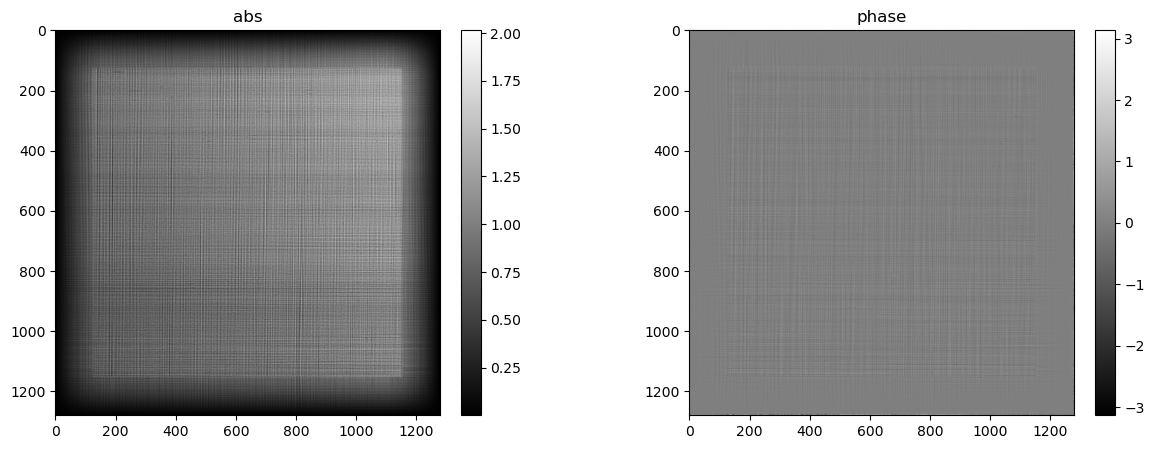

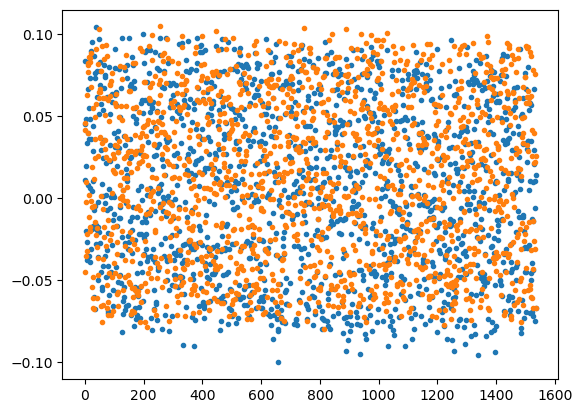

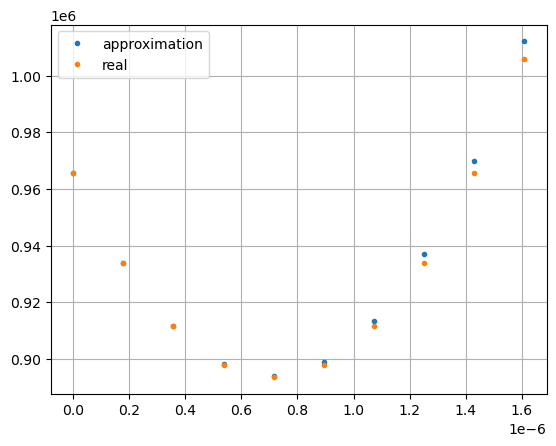

13) err=8.94041e+05
14) err=8.23814e+05
15) err=7.61997e+05
16) err=7.15292e+05


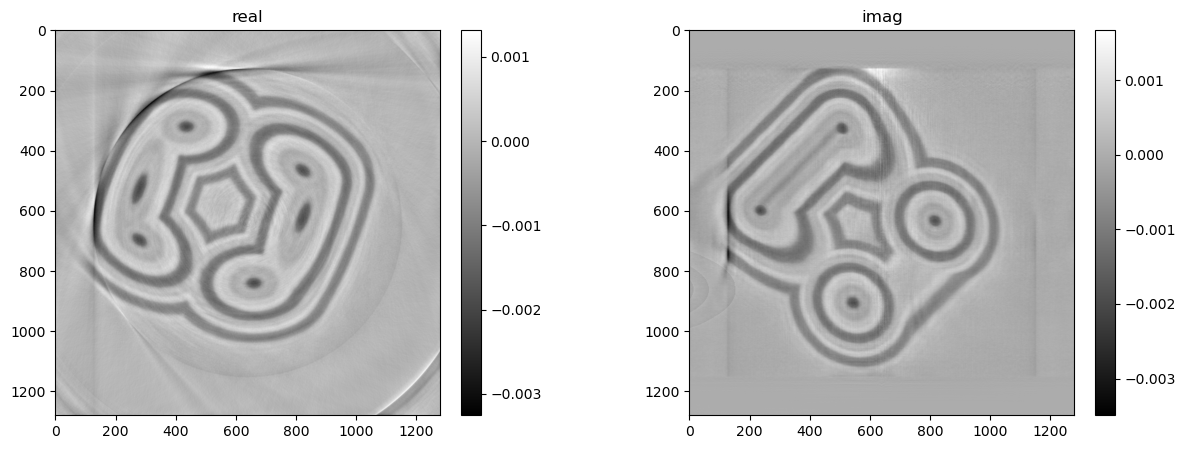

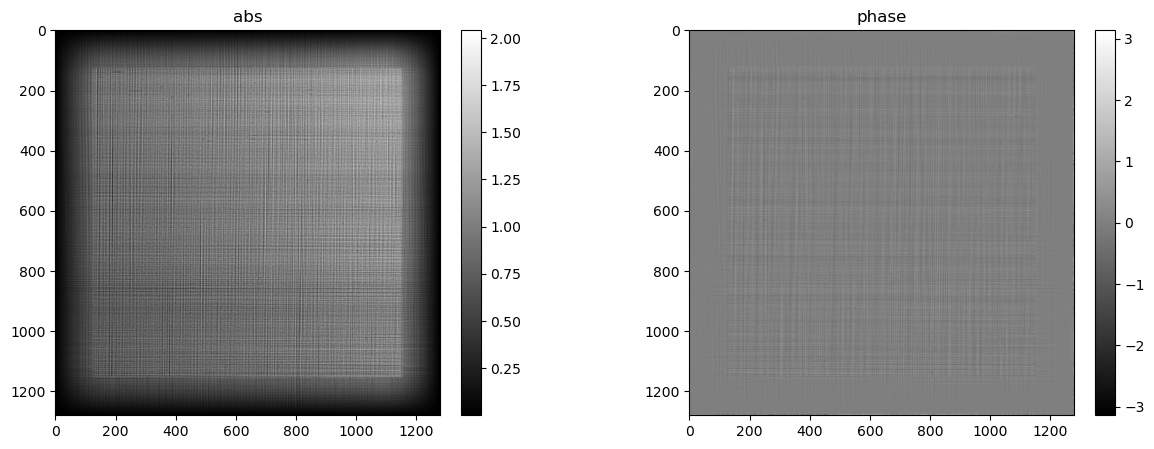

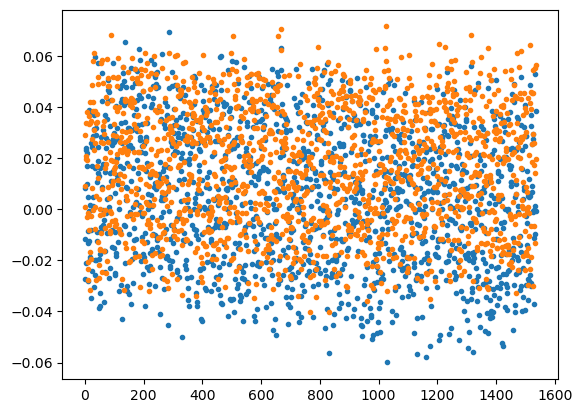

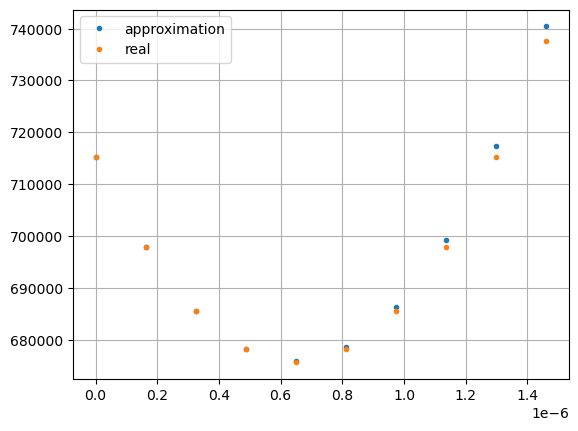

17) err=6.75855e+05
18) err=6.27422e+05
19) err=5.82667e+05
20) err=5.49417e+05


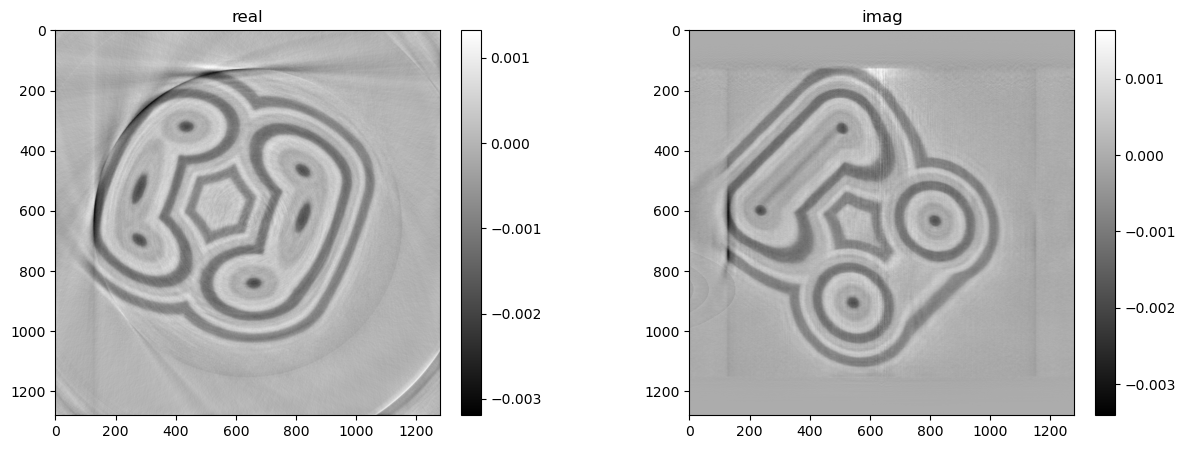

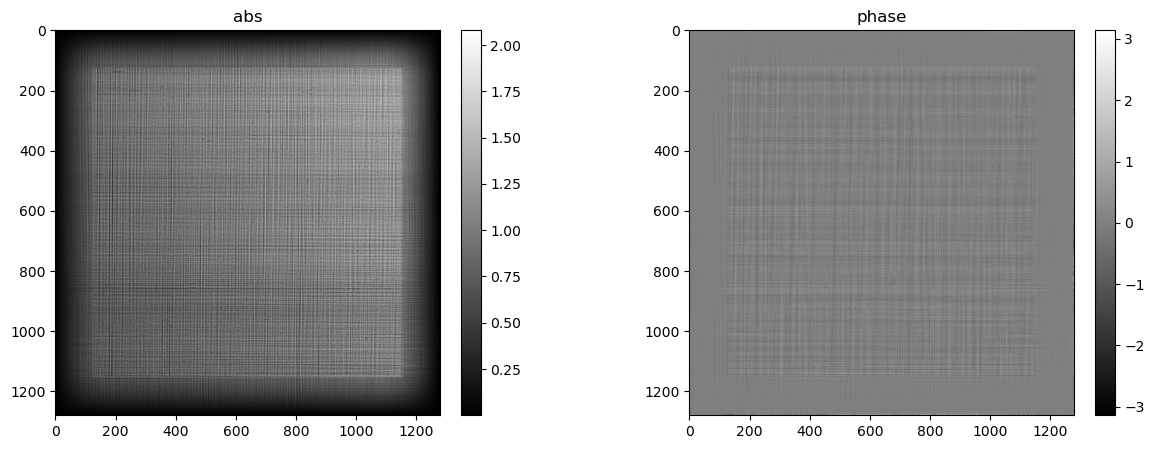

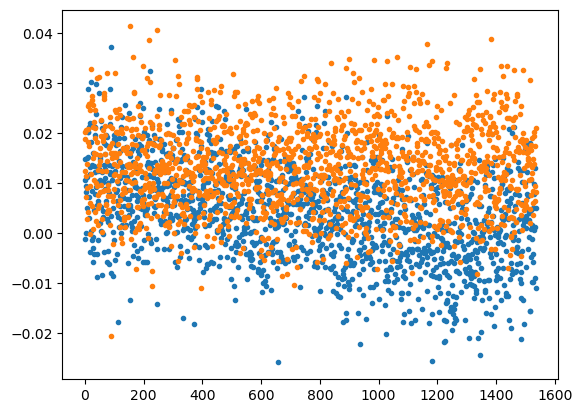

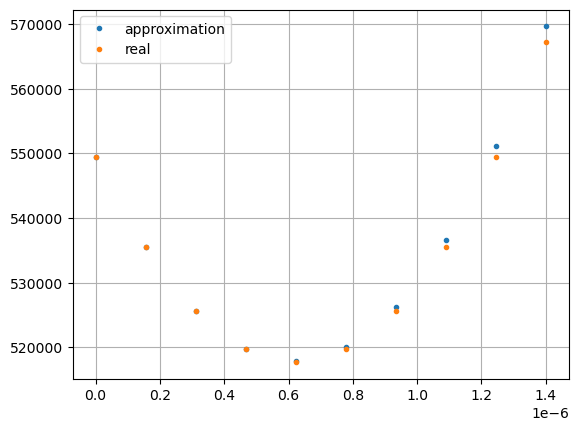

21) err=5.17892e+05
22) err=4.89098e+05
23) err=4.64872e+05
24) err=4.42040e+05


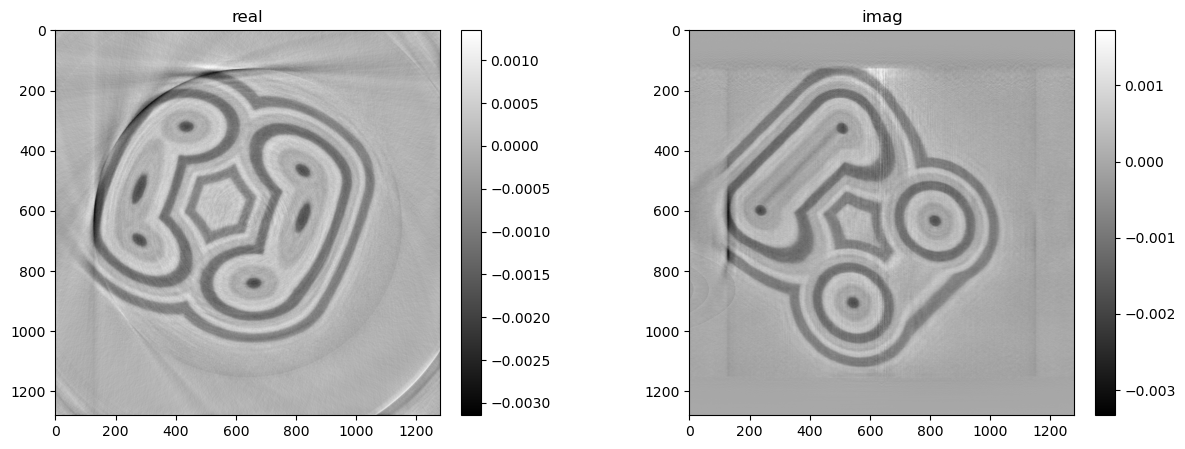

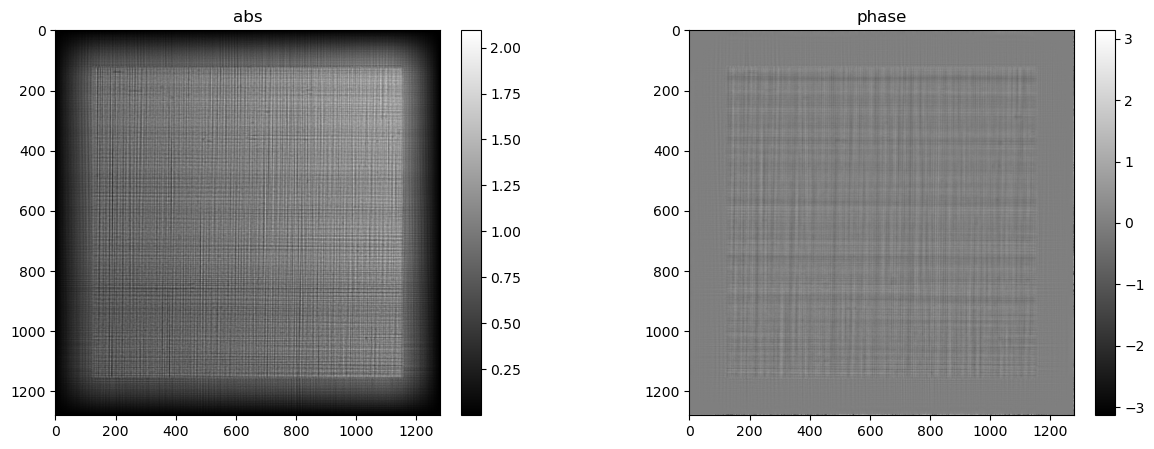

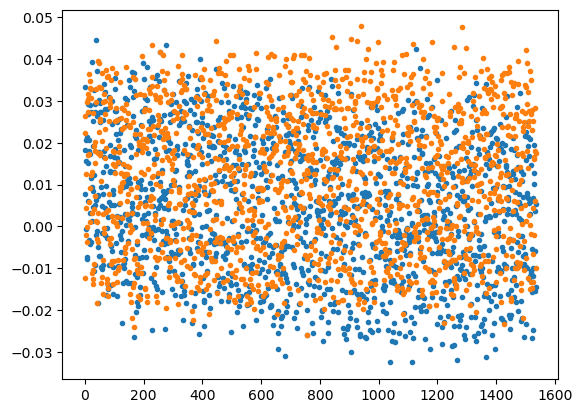

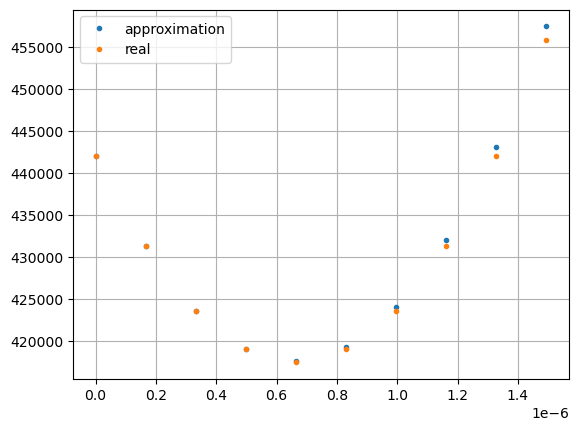

25) err=4.17628e+05
26) err=3.94889e+05
27) err=3.75811e+05
28) err=3.59409e+05


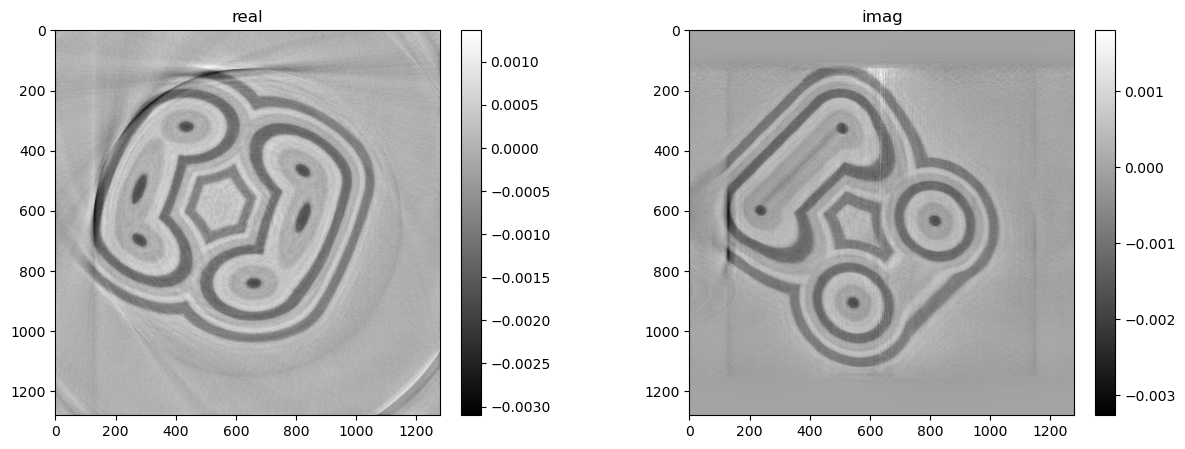

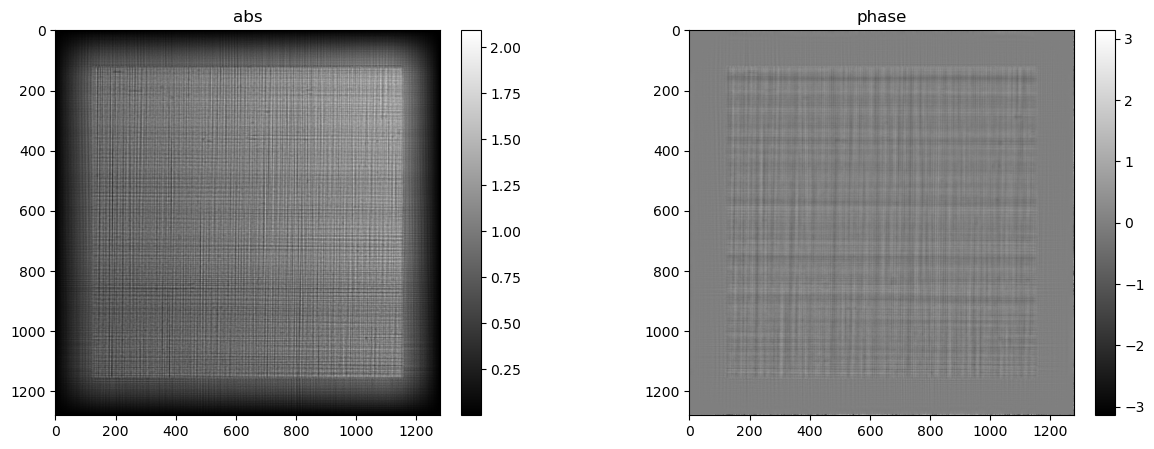

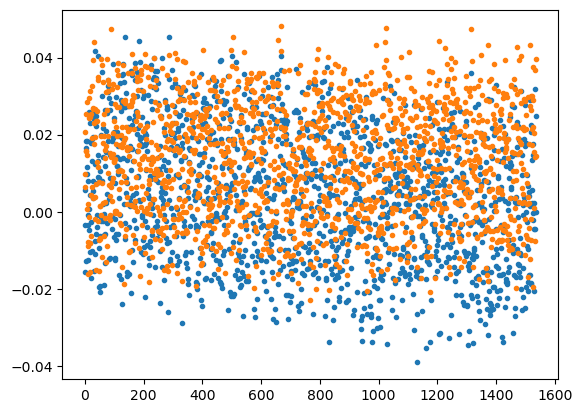

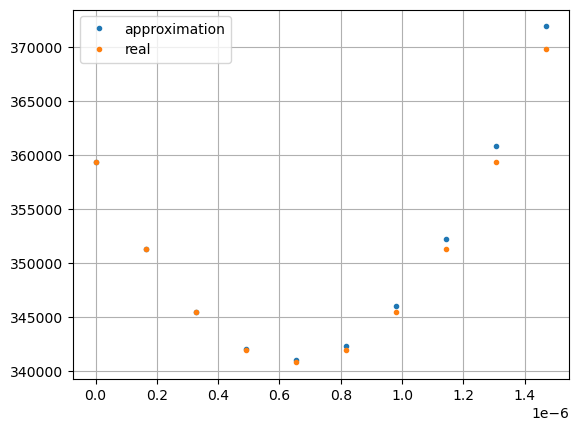

29) err=3.41024e+05
30) err=3.23438e+05
31) err=3.06570e+05


In [ ]:
vars = {}
vars["code"] = cp.array(code)
vars["u"] = np.array(u_init)#0*cp.array(u*c).astype('complex64')#cp.zeros([args.npsi,args.npsi,args.npsi],dtype='complex64')
vars["Ru"] = cl_rec.R(vars['u'])#cp.zeros([args.ntheta,args.npsi,args.npsi],dtype='complex64')
vars["psi"] = cl_rec.expR(vars['Ru'])#cp.ones([args.ntheta,args.npsi,args.npsi],dtype='complex64')
vars["q"] = cp.array(q_init)
shifts_code_init = np.array(shifts_code)+1*(np.random.random([args.ntheta,2])-0.5).astype('float32')
vars["ri"] = np.round(shifts_code_init).astype("int32")
vars["r"] = np.array(shifts_code_init - vars["ri"]).astype("float32")
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])

args.rho=[1,20,10]
args.niter=512
args.vis_step=4
args.method = "BH-CG"
cl_rec = Rec(args)
# data=cp.array(data)
# reconstruction
vars = cl_rec.BH(data, vars)
print(vars['table']['err'][0])
plt.plot(vars['table']['err'],label=f'20')    
plt.grid()
plt.legend()
plt.show()

